<a href="https://colab.research.google.com/github/amkusmec/CERIS_PAG/blob/main/CERIS_JGRA_demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates the CERIS-JGRA framework for identifying critical environmental variables underlying phenotypic plasticity. CERIS is a procedure for systematically linking environmental variation to phenotypic variation. The critical environmental variable identified by CERIS is used to parameterize reaction norms that can be used as inputs to QTL mapping and GWAS to dissect the genetics of phenotypic plasticity. JGRA combines these reaction norms with genomic prediction to enable environmentally-informed prediction of phenotypes and in-season forecasting.

More details about CERIS-JGRA and multiple applications can be found in the following publications:

* Li X. *et al.* (2018) Genomic and environmental determinants and their interplay underlying phenotypic plasticity. *PNAS* **115**(26): 6679-6684. doi: [10.1073/pnas.1718326115](https://doi.org/10.1073/pnas.1718326115)
* Guo T. *et al.* (2020) Dynamic effects of interacting genes underlying rice flowering-time phenotypic plasticity and global adaptation. *Genome Res.* **30**: 673-683. doi: [10.1101/gr.255703.119.30](https://doi.org/10.1101/gr.255703.119.30)
* Li X. *et al.* (2021) An integrated framework reinstating the environmental dimension for GWAS and genomic selection in crops. *Mol. Plant* **14**(6): 874-887. doi: [10.1016/j.molp.2021.03.010](https://doi.org/10.1016/j.molp.2021.03.010)
* Mu Q. *et al.* (2022) Phenotypic plasticity in plant height shaped by interaction between genetic loci and diurnal temperature range. *New Phytologist* **233**(4): 1768-1779. doi: [10.1111/nph.17904](https://doi.org/10.1111/nph.17904)

For questions, comments, and corrections, please contact:

- Jianming Yu (jmyu@iastate.edu)
- Xianran Li (xianran.li@wsu.edu)
- Aaron Kusmec (amkusmec@iastate.edu)

# Setup

Run the following code block to load the data, packages, and functions required for CERIS-JGRA.

In [ ]:
system("git clone https://github.com/amkusmec/CERIS_PAG/")

if (!require(colorspace)) install.packages("colorspace")
if (!require(rrBLUP)) install.packages("rrBLUP")

library(colorspace)
library(rrBLUP)

# Color scales for plotting
col_wdw <- 25;
col_palette <- diverge_hcl(col_wdw + 1, h = c(260, 0), c = 100, l = c(50, 90), power = 1)
gray_alpha <- rgb(128, 128, 128, alpha = 35, maxColorValue = 255)
poly_alpha <- rgb(238, 130, 238, alpha = 55.5, maxColorValue = 255)

# This is the location of the files cloned into your Google Drive
cwd <- '/content/CERIS_PAG/'

r_files <- list.files(paste0(cwd, "R"), "*", full.names = TRUE)
for (f in r_files) source(f)

Loading required package: colorspace

Loading required package: rrBLUP

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘rrBLUP’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Experiment selection

Modify the values for `experiment` and `trait` in the next code block to select an organism and trait for analysis. Only datasets with `Yes` in the `SNPs?` column can be used for genomic prediction of reaction norms (JGRA) after performing CERIS.

Experiment | Trait | Trait name            | SNPs?
-------- | ---------- | --------------------- | -----
Maize    | FT         | Flowering time (days) | Yes
         | PH         | Plant height          |
Oat      | FTdap      | Flowering time (days) | No
         | PH         | Plant height          |
         | GY         | Grain yield           |
Rice     | FTdap      | Flowering time (days) | Yes
         | FTgdd      | Flowering time (GDD)  |
Sorghum  | FTdap      | Flowering time (days) | Yes
         | FTgdd      | Flowering time (GDD)  |

In [ ]:
experiment <- "Sorghum"
trait <- "FTgdd"

CERIS requires phenotypic data recorded in at least two environments. The following code loads the selected example dataset and computes the mean phenotype for each line within each environment for demonstration. The aggregation step can be modified according to the experimental design.

In [ ]:
exp_dir <- paste(cwd, experiment, '/', sep = '')

# Load the phenotypic data
exp_traits_file <- paste(exp_dir, 'Traits_record.txt', sep = '')
exp_traits <- read.table(exp_traits_file, sep = "\t", header = T, stringsAsFactors = F, na.string = 'NA')

# Standardize the format of the trait data
lInd <- which(colnames(exp_traits) == 'line_code')
eInd <- which(colnames(exp_traits) == 'env_code')
tInd <- which(colnames(exp_traits) == trait)

exp_trait <- exp_traits[, c(lInd, eInd, tInd)]
colnames(exp_trait)[3] <- 'Yobs'

# Average across replicates within environments to reduce to one observation
# per line per environment
exp_trait <- aggregate(Yobs ~ line_code + env_code, exp_trait, mean, na.rm = TRUE)
exp_trait <- exp_trait[!is.na(exp_trait$Yobs), ]

line_codes <- unique(exp_trait$line_code)

# Report some details
head(exp_trait)
cat("Total observations:", nrow(exp_trait), "\n")
cat("Unique lines:", length(line_codes), "\n")
cat("Unique environments:", length(unique(exp_trait$env_code)), "\n")

,line_code,env_code,Yobs
,<chr>,<chr>,<dbl>
1,E10,IA13,2037.960
2,E100,IA13,1863.785
3,E101,IA13,1845.605
4,E102,IA13,1734.530
5,E103,IA13,2097.980
6,E104,IA13,1963.830


Total observations: 1659 
Unique lines: 237 
Unique environments: 7 


CERIS also requires daily weather data for one or more environmental variables in each environment. These could be direct measurements of typical weather variables, such as minimum and maximum temperature, or derived measurements based on the biology of the study organism, such as growing degree days (GDD) or photothermal time (PTT; GDD multiplied by day length). Such data are often collected by weather stations placed in each environment. There are also publicly available sources of environmental data, such as [NASA POWER](https://power.larc.nasa.gov/).

In [ ]:
# Load the environment metadata file
# Column `PlantingDate` should be formatted "YYYY-MM-DD" for proper parsing
env_meta_file <- paste(exp_dir, 'Env_meta_table.txt', sep = '')
env_meta_info_0 <- read.table(env_meta_file, header = T, sep = "\t", stringsAsFactors = F)

# Load the daily environmental data
all_env_codes <- unique(exp_traits$env_code)
env_cols <- rainbow_hcl(length(all_env_codes), c = 80, l = 60, start = 0, end = 300, fixup = TRUE, alpha = 0.75)

envParas_file <- paste0(exp_dir, length(all_env_codes), 'Envs_envParas.txt')
if (!file.exists(envParas_file) ) {
  envParas <- Compile_Envirome_Matrix(exp_dir, all_env_codes)
} else {
  envParas <- read.table(envParas_file, sep = "\t", header = T, stringsAsFactors = F, na.string = "NA")
  if (!("DAP" %in% names(envParas))) {
    params <- setdiff(names(envParas), c("env_code", "date"))
    envParas <- split(envParas, envParas$env_code)
    envParas <- lapply(envParas, function(df) {
            df$DAP <- 0:(nrow(df) - 1)
            df[, c("env_code", "DAP", params)]
    })
    envParas <- do.call("rbind", envParas)
  }
}

# Names of the environmental parameters
Paras <- names(envParas)[-(1:2)]

# Report some details
head(envParas)
cat("Total parameters:", length(Paras), "\n")
cat("Maximum DAP:", max(envParas$DAP), "\n")

,env_code,DAP,DL,GDD,PTT,PTR,PTS
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PR12,0,11.85,24.30,287.9550,2.050633,187801.05
2,PR12,1,11.87,26.55,315.1485,2.236731,252384.39
3,PR12,2,11.85,28.80,341.2800,2.430380,318680.44
4,PR12,3,11.85,25.20,298.6200,2.126582,304121.43
5,PR12,4,11.85,21.60,255.9600,1.822785,72390.61
6,PR12,5,11.83,20.70,244.8810,1.749789,106859.38


Total parameters: 5 
Maximum DAP: 121 


The average phenotype across all lines grown within an environment is a useful parameter for assessing environmental quality and forms the basis of CERIS as discussed in the next two sections. The following code computes the environment-wise mean phenotypes and reformats the data for ease of analysis.

In [ ]:
# Calculate the environmental mean phenotype
env_mean_trait_0 <- aggregate(Yobs ~ env_code, exp_trait, mean, na.rm = TRUE)
colnames(env_mean_trait_0)[2] <- 'meanY'
env_mean_trait <- merge(env_mean_trait_0, env_meta_info_0)
env_mean_trait <- env_mean_trait[order(env_mean_trait$meanY), ]

# Reformat the phenotypic data
env_codes <- env_mean_trait$env_code
line_by_env_df <- data.frame(line_code = line_codes, stringsAsFactors = T)
for (e_i in 1:nrow(env_mean_trait)) {
  e <- env_codes[e_i]
  e_trait <- subset(exp_trait, exp_trait$env_code == e)
  nonNAs <- length(which(!is.na(e_trait[, 3])))
  colnames(e_trait)[3] <- e
  line_by_env_df <- merge(line_by_env_df, e_trait[, c(1, 3)], all.x = T)
}

# Report some details
env_mean_trait

,env_code,meanY,env_notes,lat,lon,PlantingDate,TrialYear,Location
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<int>,<chr>
6,PR12,1507.464,2,18.0373,-66.7963,2011-12-12,2011,PR
2,IA14,1550.804,6,42.0308,-93.6319,2014-06-10,2014,IA
5,PR11,1556.628,1,18.0373,-66.7963,2010-12-04,2010,PR
1,IA13,1859.120,5,42.0308,-93.6319,2013-06-05,2013,IA
7,PR14S,1937.385,7,18.0373,-66.7963,2014-06-05,2014,PR
3,KS11,2289.254,3,39.1836,-96.5717,2011-06-08,2011,KS
4,KS12,2459.633,4,39.1836,-96.5717,2012-06-07,2012,KS


# Joint regression analysis (JRA)

Phenotypic plasticity often generates apparently complex patterns in multi-environment trial data. A straightforward analysis is to treat data from each environment as a distinct phenotype and perform a multi-trait analysis. However, this becomes computationally challenging when the number of environments is large. By choosing an appropriate ordering for the environments, it is often possible to model plasticity using a more parsimonious model.

Two natural orderings suggest themselves. First, ordering by the latitudes of the environments captures major gradients in temperature and day length, which are critical factors in plant development. Second, ordering by the environment-wise mean phenotypes captures overall environmental quality as measured by the performance of the lines grown in that environment, effectively integrating over all relevant environmental variables. The following plots illustrate these orderings. Each thin line connects the observations for a single line across all environments.

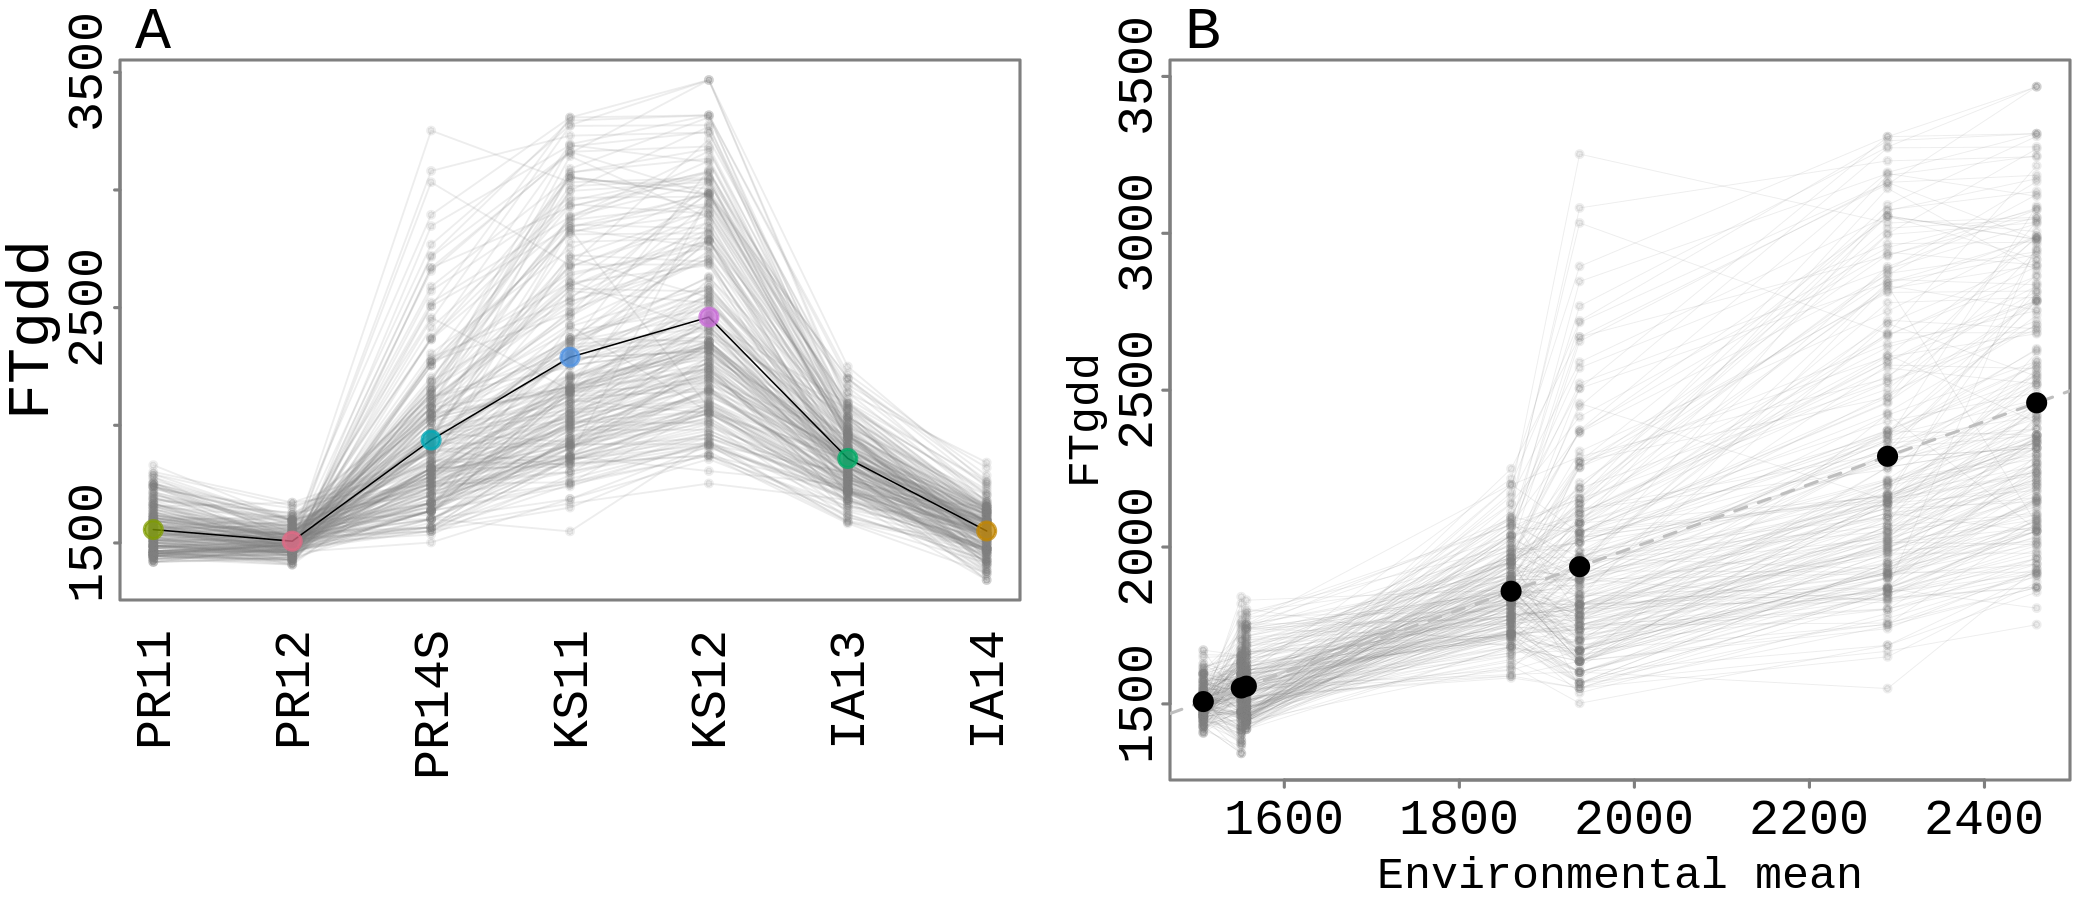

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 300)

# Plot two different orderings of the environments
layout(matrix(1:2, ncol = 2))

# First, ordered by latitude, longitude, and planting date
plot_geoOrder(env_mean_trait, env_meta_info_0, line_by_env_df, trait)
mtext('A', side = 3, at = 1, cex = 1.2)

# Second, ordered by the environmental mean phenotype
plot_envMeans(env_mean_trait, line_by_env_df, trait)
mtext('B', side = 3, at = min(env_mean_trait$meanY), cex = 1.2)

The geographic ordering (panel A) does not necessarily suggest a parsimonious model for performance across environments. Often, many cross-over interactions are observed. Ordering by environment-wise means (panel B), however, often suggests that a simple linear model is an adequate approximation.

This is the basis of joint regression analysis (JRA) which models the phenotypic performance of a line on the average performance of all lines grown in each environment. The JRA model is given by

$y_{ij}=\mu_i+\beta_iI_j+\delta_{ij}$

where $y_{ij}$ is the mean phenotype of the $i$th line in the $j$th environment; $\mu_i$ is the mean phenotype of the $i$th line over all environments; $\beta_i$ is a regression coefficient that measures the response of the $i$th line to environmental quality; $I_j$ is the environment-wise mean phenotype, used as a proxy for environmental quality; and $\delta_{ij}$ is a residual.

The JRA model represents a phenotype using two parameters. $\mu_i$ measures the average performance of a line across all environments. $\beta_i$ measures the plasticity of a line, i.e., its sensitivity to environmental conditions. The following code applies the JRA model to the selected dataset and illustrates the fitted reaction norms.

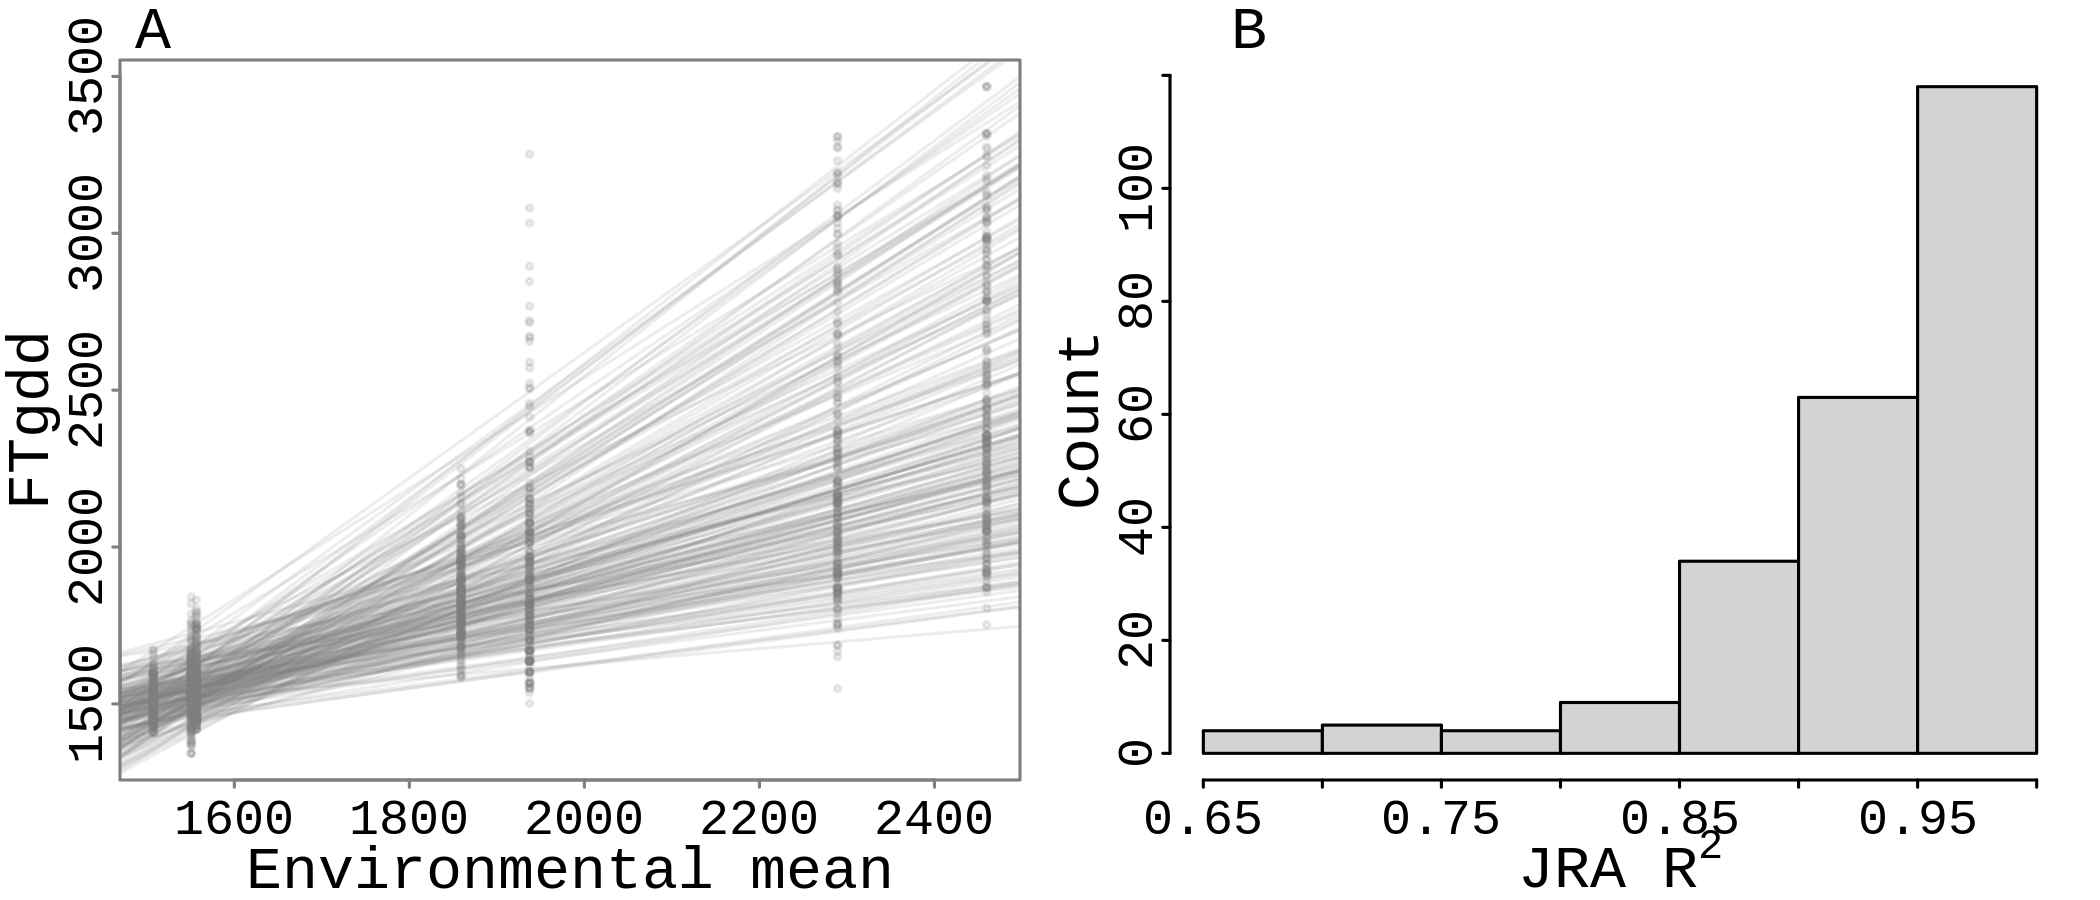

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 300)

# JRA and plots
jra_res <- JRA_Model(line_by_env_df, env_mean_trait)
plot_JRAResults(env_mean_trait, line_by_env_df, jra_res, trait)

Panel A illustrates the fitted reaction norms from the JRA model. If the linear model is a good approximation, the range of the reaction norms should approximate the range of the observed phenotypes in each environment. Panel B plots the regression $R^2$ for each line.

The parameters from the JRA model could be used as inputs for QTL mapping or GWAS. However, there are some limitations to the JRA model:

1. Using the environmental mean phenotype does not provide any information about the environmental variable(s) driving the observed plasticity.
2. Environmental mean phenotype can only be calculated after the fact, precluding prediction of performance in untested environments.

These two limitations suggest the need for a biologically meaningful index that is associated with average performance but can be calculated independently of phenotypic observations.

# Critical environmental regressors through informed search (CERIS)

CERIS is a strategy to identify an environmental index that addresses the two limitations of the JRA model outlined in the previous section.

If the study population is large, the environmental mean phenotypes as calculated in the JRA model summarize the effect of the environment on the entire population. CERIS systematically computes the correlations between the environmental mean phenotypes and environmental variables to identify the variable that best captures the observed environmental differences. The variable with the strongest correlation is chosen as an environmental index.

The set of environmental variables can include direct measurements of environmental parameters (e.g., minimum temperature) and/or derived parameters that directly incorporate biological information (e.g., GDD) or not (e.g., diurnal temperature range). Spurious results can be avoided by judicious choice of input variables based on prior information about an organism's development.

Variables are summarized by their average across sliding windows covering the growing season. Assuming a minimum window length of 7 days, CERIS systematically correlates environmental mean phenotypes with the average of a variable for 1-7 days after planting (DAP), 2-8 DAP, 3-9 DAP, etc. This repeats with windows of length 8 days, 9 days, etc. until all possible windows have been tested.

The following code runs CERIS for the selected dataset and displays the results.

[==================================================] 100%

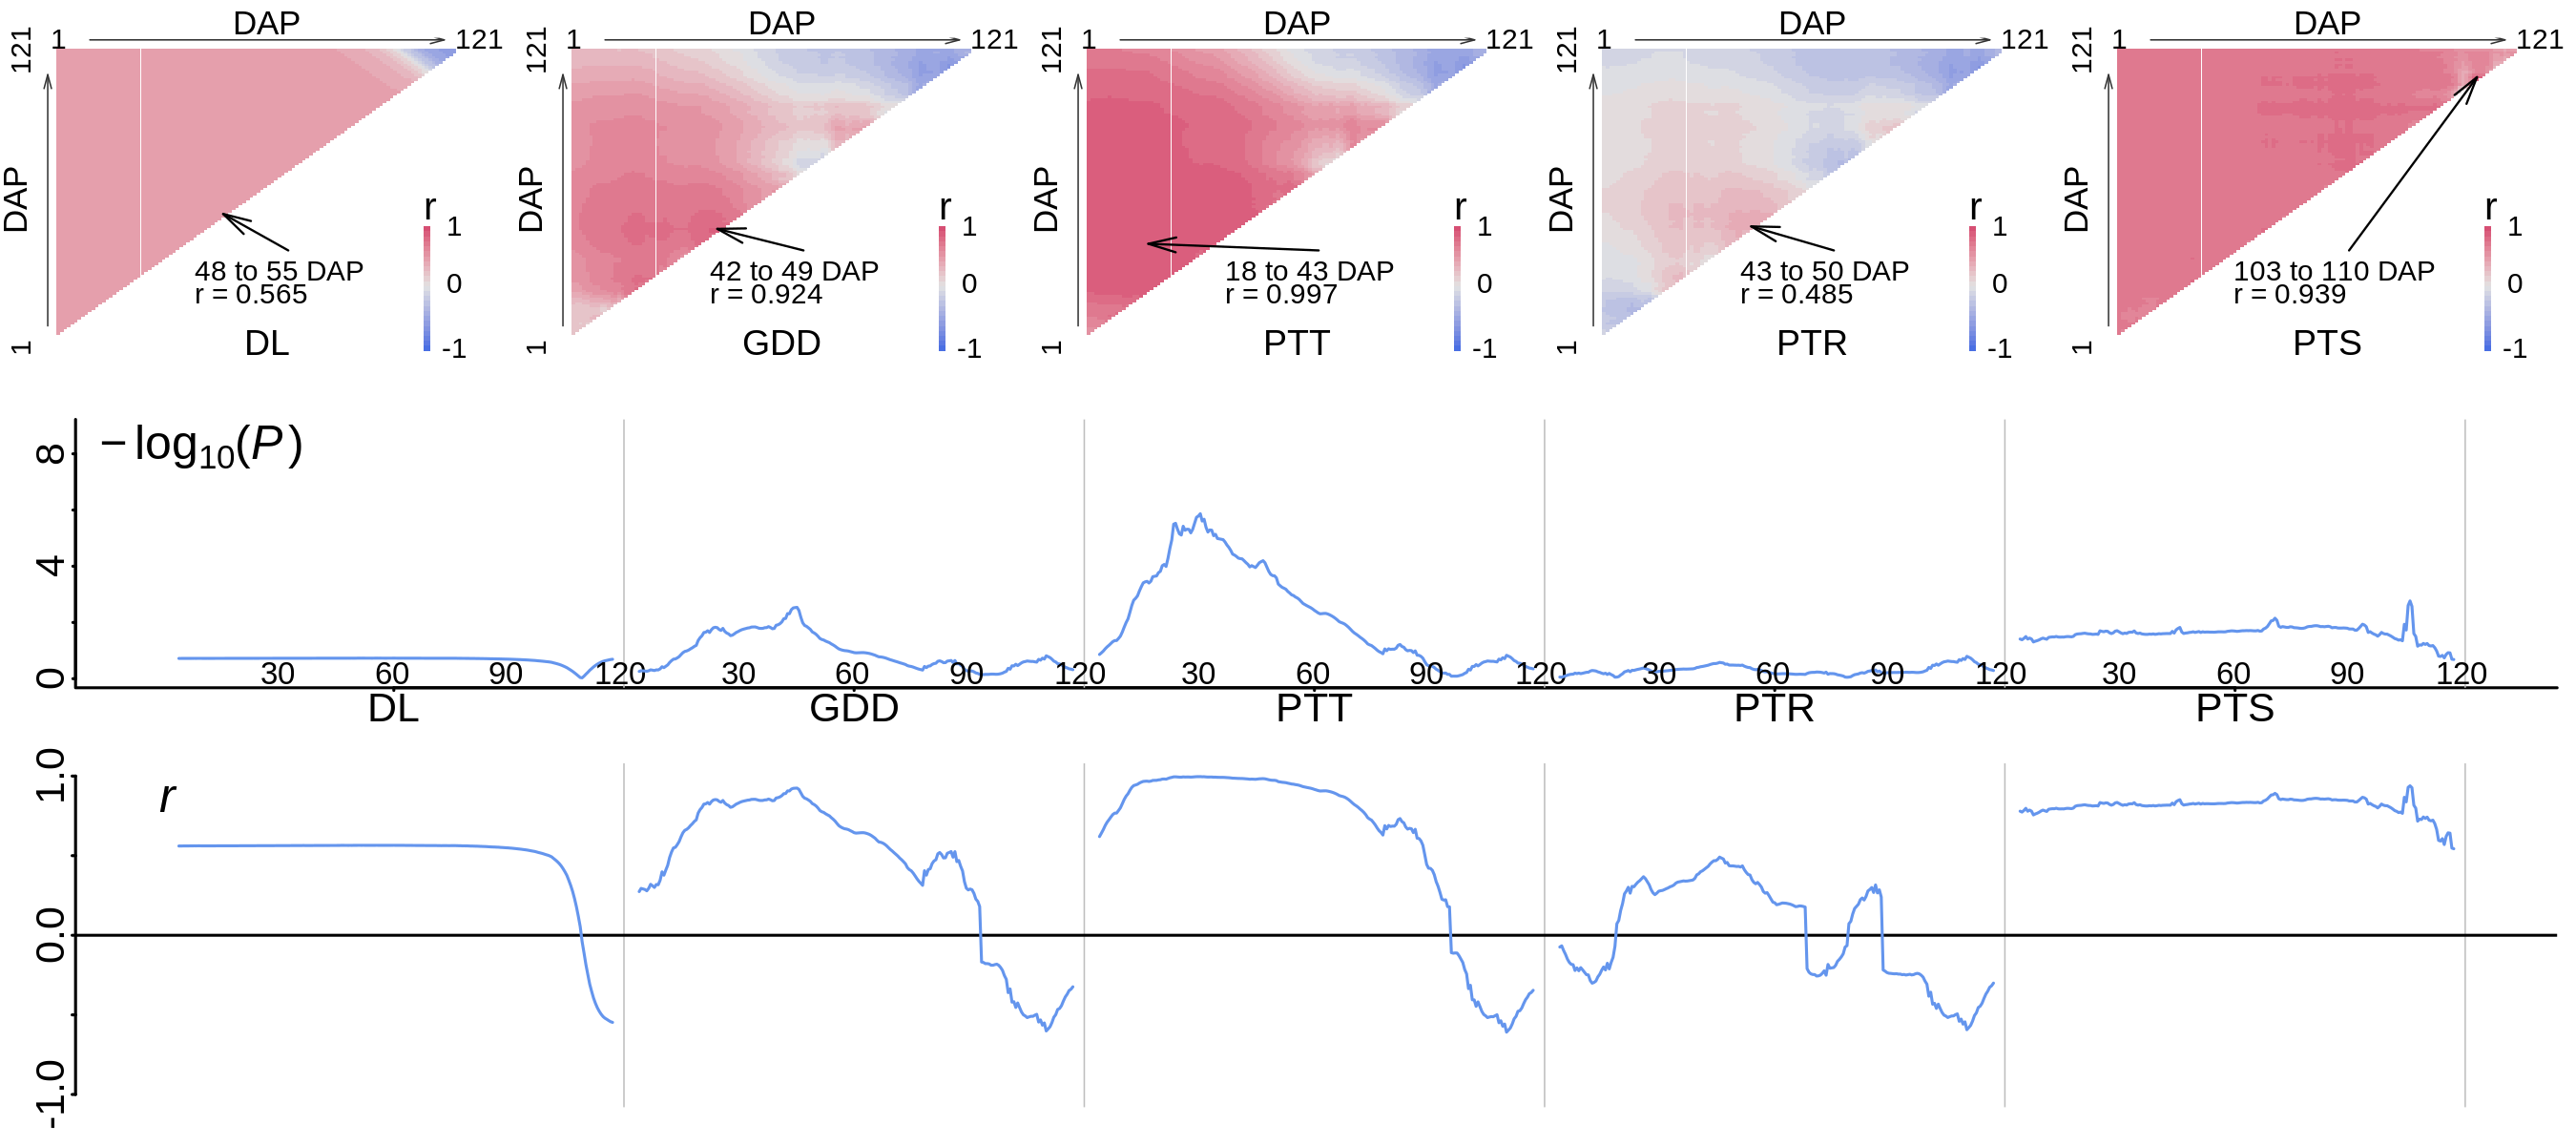

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 4, repr.plot.res = 300)

ceris_res <- CERIS(env_mean_trait, envParas, Paras)
source(paste0(cwd, "R/plot_CERIS.R"))
plot_CERIS(ceris_res, Paras, max(envParas$DAP))

The top row of plots displays the strength of the correlation between environmental mean phenotypes and the indicated environmental variable for a given window. Black arrows indicate the maximum correlation for each variable. The middle and bottom rows depict the maximum significance of the correlation and its value, respectively, for windows centered on the indicated day after planting (This is the maximum correlation along the diagonals of the heatmaps). An ideal environmental index has both a high correlation and significance relative to other environmental variables and to nearby windows.

The next code block identifies the best environmental variable and window and plots the index against the environmental mean phenotypes.

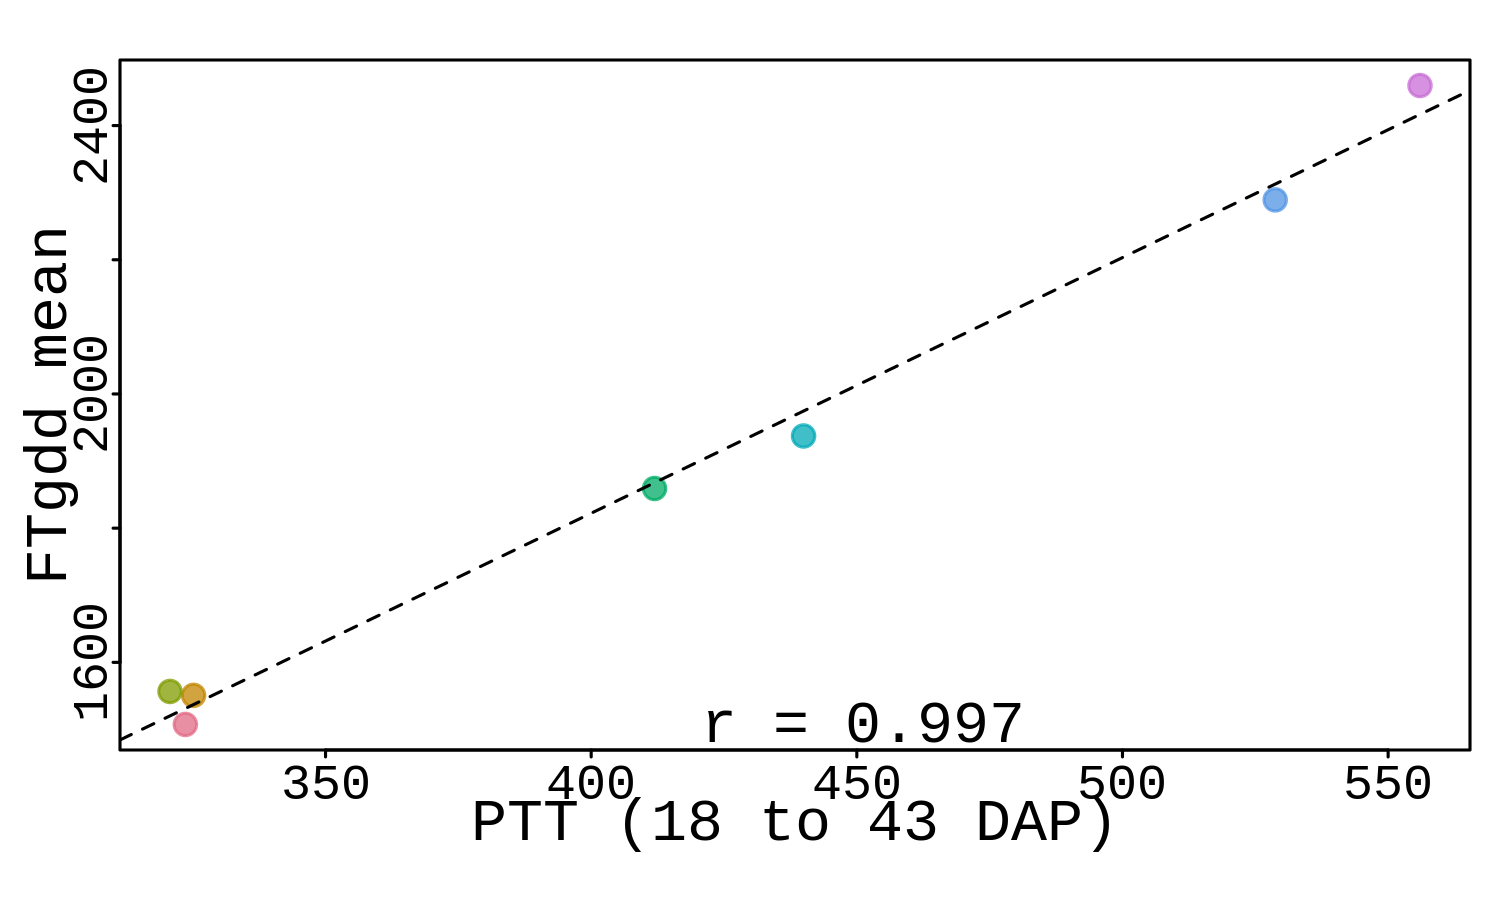

In [ ]:
# Identify the best window and parameter
idxR <- match(paste0("R_", Paras), colnames(ceris_res))
maxR <- arrayInd(which.max(abs(ceris_res[, idxR])), .dim = dim(ceris_res[, idxR]))

kPara_Name <- Paras[maxR[1, 2]]
maxR_dap1 <- ceris_res[maxR[1, 1], 2]
maxR_dap2 <- ceris_res[maxR[1, 1], 3]

# Compile average covariate values for the best window and parameter
env_mean_trait$kPara <- as.numeric(NA)
for (e_i in 1:nrow(env_mean_trait)) {
  e <- env_mean_trait$env_code[e_i]
  env_mean_trait$kPara[e_i] <- mean(subset(envParas, env_code == e)
                                    [maxR_dap1:maxR_dap2, kPara_Name])
}

# Plot the best parameter vs. phenotype means
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)
plot_traitMean_kPara(env_mean_trait, trait, kPara_Name, maxR_dap1, maxR_dap2)

The best environmental index and the correlation are shown on the $x$-axis. The dashed line is the regression of environmental mean phenotype on the index. A low correlation indicates that a relevant environmental variable was not included, the most important window was not included, that a linear model is not a good approximation for the phenotype, or some combination of those factors.

With a good environmental index, reaction norms can be calculated as with the JRA model except that the slopes now express the change in the phenotype with respect to the performance-free environmental index.

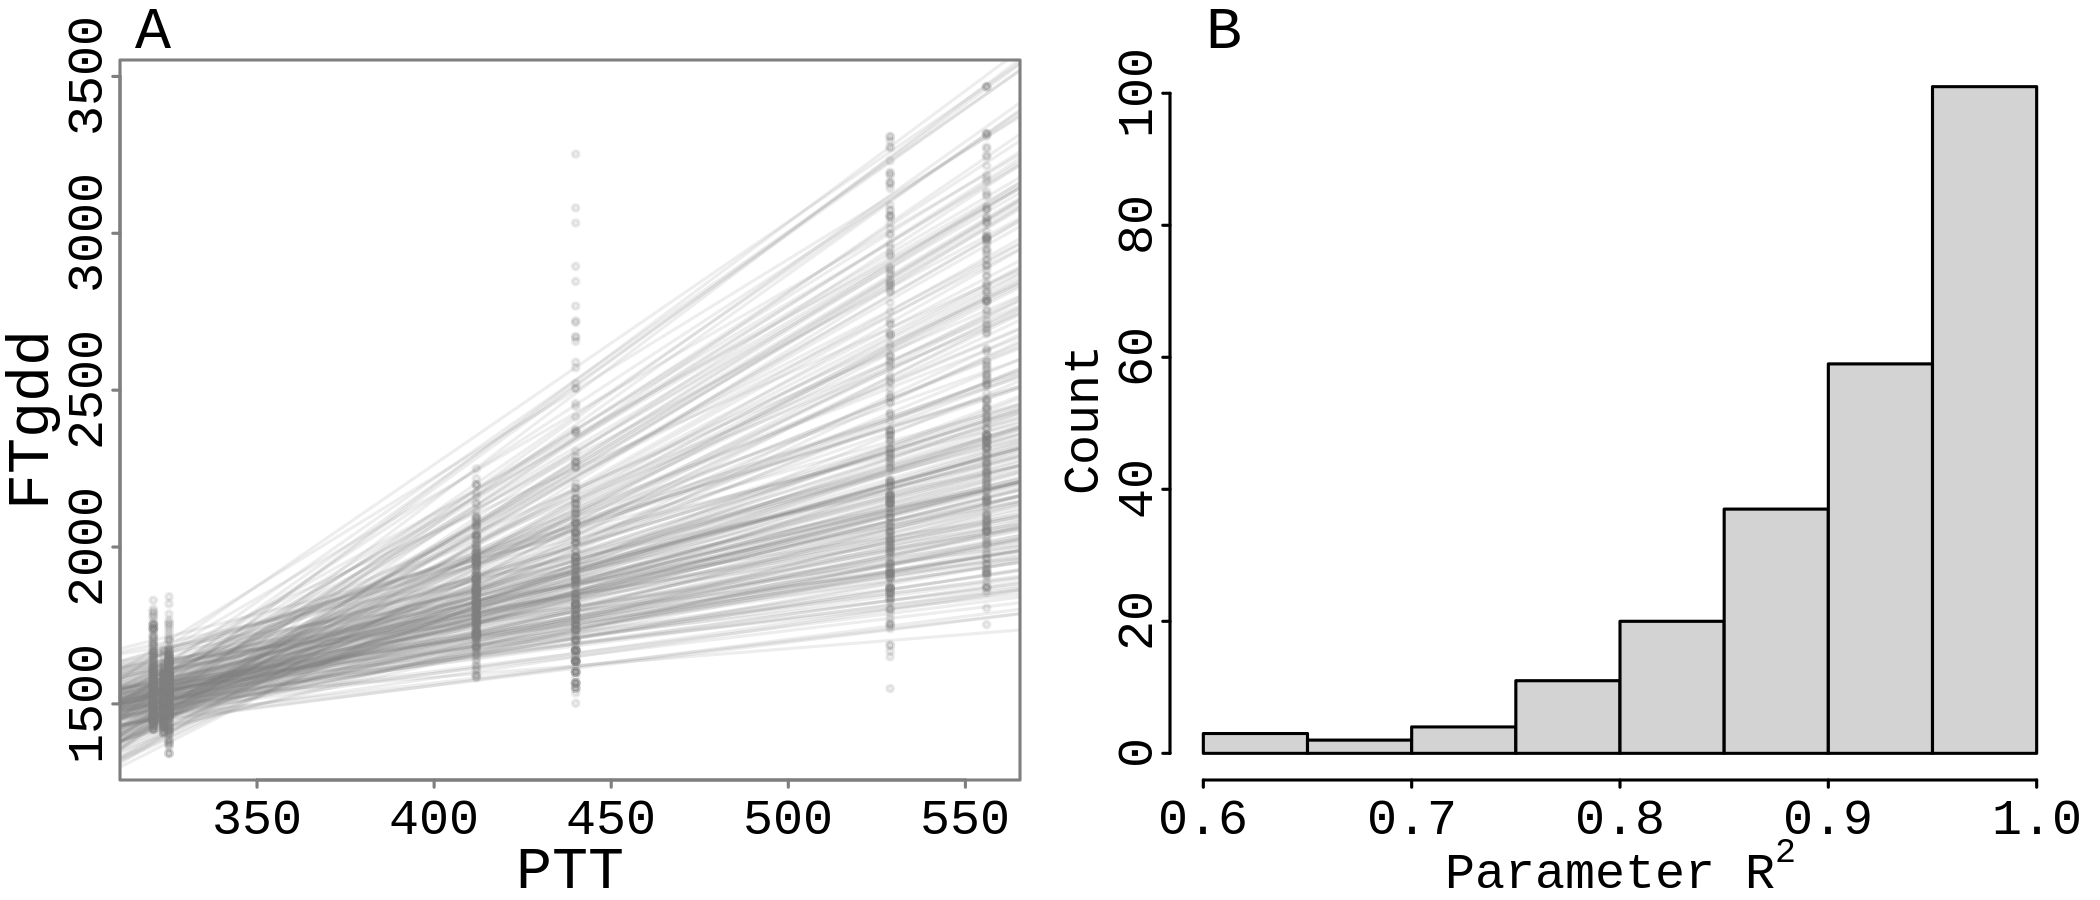

In [ ]:
# Calculate slopes and intercepts using the best window and parameter
res_para <- slopeIntercept(exp_trait, env_mean_trait)

# Plot the reaction norms
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 300)
plot_slopeIntercept(merge(exp_trait, env_mean_trait, by = "env_code"),
                    res_para, trait, kPara_Name)

# Joint genomic regression analysis (JGRA)

Genomic prediction (GP) across environments is challenging when the relevant environmental variables are unknown. In the absence of an environmental index, the best predictions are often simply predicted average performance across environments. However, in the presence of phenotypic plasticity, this will perform poorly when the target environment differs from the mean environment of the training data.

The environmental index identified by CERIS provides a tool to link tested and untested environments in prediction models. The reaction norm parameters specific to that environmental index can be treated as phenotypes for GP. Given marker data on a population, GP models for reaction norm parameters of untested lines can be predicted and translated into performance in a new environment using the environmental index.

The next code block sets two parameters for demonstrating GP with CERIS.

In [ ]:
#  gFold      = number of cross-validation folds
#  gIteration = number of times to perform cross-validation (only the results
#               of the first iteration will be displayed)
gFold <- 5
gIteration <- 1

The following code demonstrates three cross-validation scenarios.

* The "1-to-2" scenario predicts the performance of tested lines in untested environments. Each environment is dropped from the training data, reaction norm parameters are re-estimated without that environment, and then phenotypes are predicted using the value of the environmental index for the dropped environment. No GP model is fit in this scenario because reaction norm parameters are assumed to have been observed for all lines.
* The "1-to-3" scenario predicts the performance of untested lines in tested environments. Lines are split into `gFold` cross-validation folds, and the reaction norm parameters of each fold are predicted using a ridge-regression BLUP model trained on the remaining folds. Phenotypes are predicted using the predicted parameters and environmental index from CERIS. Models are trained using the reaction norm parameters estimated from *all* environments.
* The "1-to-4" scenario predicts the performance of untested lines in untested environments. Reaction norm parameters are re-estimated for a subset of observed lines after dropping an environment as in the 1-to-2 scenario. Phenotypes are predicted with a GP model as in the 1-to-3 scenario trained on these re-estimated reaction norm parameters. The training data for the GP model are reaction norm parameters estimated from a *subset* of the environments.

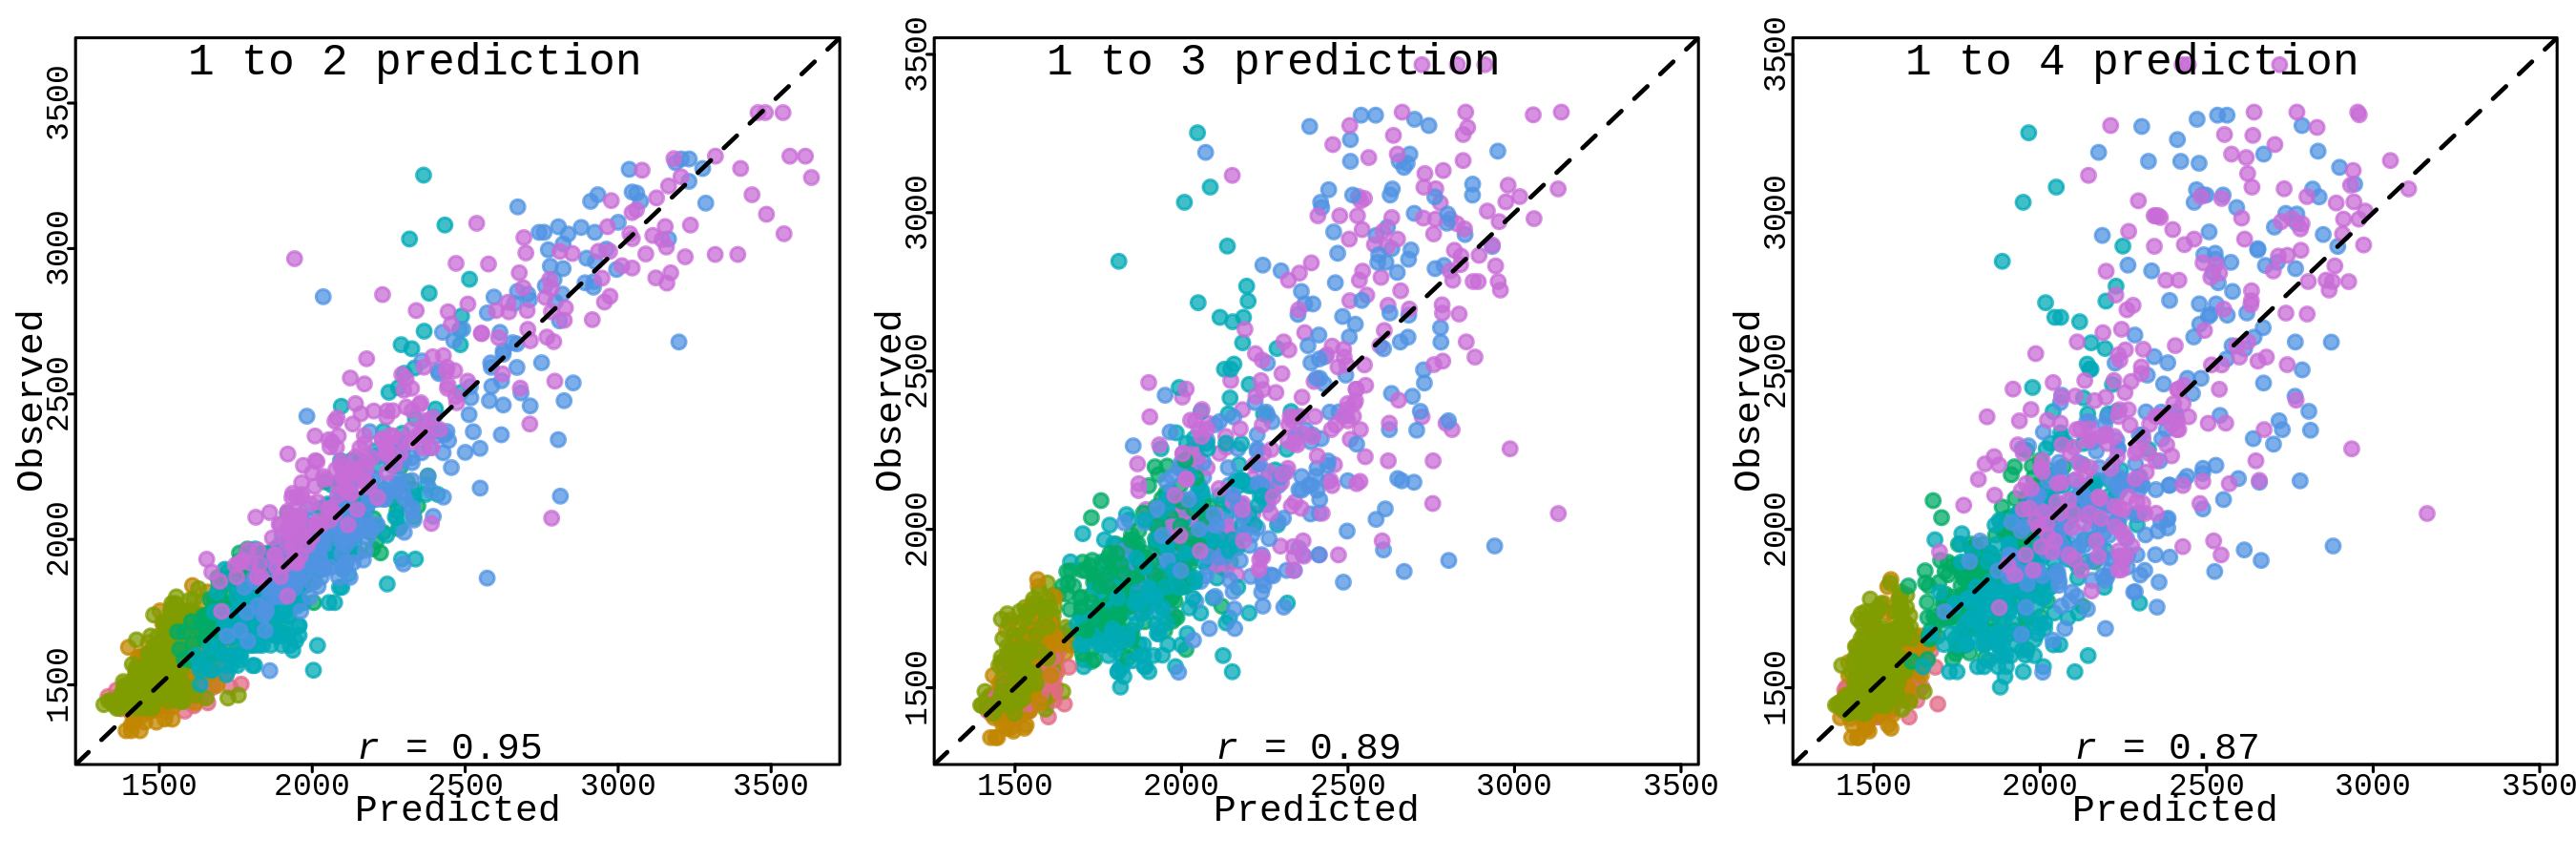

In [ ]:
# Cross-validation
SNPs_file <- paste0(exp_dir, "Genotype.txt")
if (file.exists(SNPs_file)) {
  SNPs <- read.table(SNPs_file, header = TRUE, sep = "\t")

  # Check the orientation of the SNP table
  if (!any(line_codes %in% SNPs[[1]])) {
    snp_codes <- SNPs[[1]]
    line_codes2 <- names(SNPs)[-1]
    SNPs <- t(as.matrix(SNPs[, -1]))
    dimnames(SNPs) <- list(line_codes2, snp_codes)
    rm(line_codes2, snp_codes); gc()
  } else {
    line_codes2 <- SNPs[[1]]
    SNPs <- as.matrix(SNPs[, -1])
    rownames(SNPs) <- line_codes2
    rm(line_codes2); gc()
  }

  res_1to2 <- oneTo2CV(env_mean_trait, exp_trait)
  res_1to3 <- oneTo3CV(gFold, gIteration, SNPs, res_para, env_mean_trait, exp_trait)
  res_1to4 <- oneTo4CV(gFold, gIteration, SNPs, env_mean_trait, exp_trait)

  options(repr.plot.width = 9, repr.plot.height = 3, repr.plot.res = 300)
  plotCVResults(list(res_1to2, res_1to3, res_1to4), all_env_codes)
} else {
  cat("Genomic prediction requires SNPs. Please choose a different dataset.")
}

The plots display the results of the three scenarios. Each environment is shown in a different color. The dashed line is the $y=x$ line. The correlation at the bottom of each plot is the correlation over all environments. With a good environmental index, this is often high. However, the quality of the predictions can vary within each environment.

# Conclusion

This concludes the CERIS-JGRA demonstration. You can explore differences in the results by choosing a new organism and/or trait at "Experiment selection". More details on the methods can be found in the publications listed at the top of this notebook.